# 5 Sim deaths by subgroup
The benefit of using a GREASYPOP population is that you can track outcomes for demographic subgroups both spatially and temporaly. This notebook introduces a custom `analyzer` for storing new and cumulative deaths per 1,000 by age, gender, and race. This analyzer can be customized to store outcomes by any agent attribute (columns in the file `people_all.csv`). See [Covasim Tutorial 6 - Using analyzers](https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_analyzers.html) for ways to build your own custom analyzers. 

**Input files**
- `people_all.csv`
- `greasypop.ppl`
- `observed_by_subgroup.csv`


**Output files**
- `greasypop_by_subgroup.sim`
- `greasypop_by_subgroup.csv`

In [1]:
# Import packages and set path
import covasim as cv
#cv.options(jupyter=True, verbose=0) # if you don't want to print cv output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sciris as sc
import os
from scipy.io import mmread

path = "/Users/hamilaj1/Desktop/Covasim-G/data"

Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


## 5.1 Custom analyzer for subgroups

In [2]:
class store_deaths_by_subgroup(cv.Analyzer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) # This is necessary to initialize the class properly
        self.t = [] # List for storing the time step
        self.D_black = [] # List for storing deaths corresponding to race_black_alone
        self.D_hispanic = [] # List for storing deaths corresponding to hispaic
        self.D_white = [] # List for storing deaths corresponding to white_non_hispanic
        self.D_female = [] # List for storing deaths corresponding to female
        self.D_male = [] # List for storing deaths corresponding to male
        self.D_0to9 = [] # Lists for storing deaths by age groups
        self.D_10to19 = []
        self.D_20to29 = []
        self.D_30to39 = []
        self.D_40to49 = []
        self.D_50to59 = []
        self.D_60to69 = []
        self.D_70to79 = []
        self.D_80plus = []
        return

    def apply(self, sim):
        # Identify agents with chosen characteristics
        people_black = sim.people.race_black_alone == 1
        people_hispanic = sim.people.hispanic == 1
        people_white = sim.people.white_non_hispanic == 1
        people_female = sim.people.sex == 0
        people_male = sim.people.sex == 1
        people_0to9 = sim.people.age <= 9
        people_10to19 = (sim.people.age >= 10) & (sim.people.age <=19)
        people_20to29 = (sim.people.age >= 20) & (sim.people.age <=29)
        people_30to39 = (sim.people.age >= 30) & (sim.people.age <=39)
        people_40to49 = (sim.people.age >= 40) & (sim.people.age <=49)
        people_50to59 = (sim.people.age >= 50) & (sim.people.age <=59)
        people_60to69 = (sim.people.age >= 60) & (sim.people.age <=69)
        people_70to79 = (sim.people.age >= 70) & (sim.people.age <=79)
        people_80plus = sim.people.age >= 80
        # Identify agents living in chosen state
        people_state = sim.people.state == 24 # This is Maryland's state FIPs code
        # Identify agents who have died
        people_dead = sim.people.dead
        # Identify agents who live in MD and have died by subgroup
        people_black_dead = cv.true(people_black * people_dead * people_state)
        people_hispanic_dead = cv.true(people_hispanic * people_dead * people_state)
        people_white_dead = cv.true(people_white * people_dead * people_state)
        people_female_dead = cv.true(people_female * people_dead * people_state)
        people_male_dead = cv.true(people_male * people_dead * people_state)
        people_0to9_dead = cv.true(people_0to9 * people_dead * people_state)
        people_10to19_dead = cv.true(people_10to19 * people_dead * people_state)
        people_20to29_dead = cv.true(people_20to29 * people_dead * people_state)
        people_30to39_dead = cv.true(people_30to39 * people_dead * people_state)
        people_40to49_dead = cv.true(people_40to49 * people_dead * people_state)
        people_50to59_dead = cv.true(people_50to59 * people_dead * people_state)
        people_60to69_dead = cv.true(people_60to69 * people_dead * people_state)
        people_70to79_dead = cv.true(people_70to79 * people_dead * people_state)
        people_80plus_dead = cv.true(people_80plus * people_dead * people_state)
        # Count agents who have died by subgroup for each time step
        self.t.append(sim.t)
        self.D_black.append(len(people_black_dead))
        self.D_hispanic.append(len(people_hispanic_dead))
        self.D_white.append(len(people_white_dead))
        self.D_female.append(len(people_female_dead))
        self.D_male.append(len(people_male_dead))
        self.D_0to9.append(len(people_0to9_dead))
        self.D_10to19.append(len(people_10to19_dead))
        self.D_20to29.append(len(people_20to29_dead))
        self.D_30to39.append(len(people_30to39_dead))
        self.D_40to49.append(len(people_40to49_dead))
        self.D_50to59.append(len(people_50to59_dead))
        self.D_60to69.append(len(people_60to69_dead))
        self.D_70to79.append(len(people_70to79_dead))
        self.D_80plus.append(len(people_80plus_dead))
        return

    def df(self):
        # Identify all agents (not just deceased) by subgroup so we can use the counts to calculate per 100k values
        people_black = sim.people.race_black_alone == 1
        people_hispanic = sim.people.hispanic == 1
        people_white = sim.people.white_non_hispanic == 1
        people_female = sim.people.sex == 0
        people_male = sim.people.sex == 1
        people_0to9 = sim.people.age <= 9
        people_10to19 = (sim.people.age >= 10) & (sim.people.age <=19)
        people_20to29 = (sim.people.age >= 20) & (sim.people.age <=29)
        people_30to39 = (sim.people.age >= 30) & (sim.people.age <=39)
        people_40to49 = (sim.people.age >= 40) & (sim.people.age <=49)
        people_50to59 = (sim.people.age >= 50) & (sim.people.age <=59)
        people_60to69 = (sim.people.age >= 60) & (sim.people.age <=69)
        people_70to79 = (sim.people.age >= 70) & (sim.people.age <=79)
        people_80plus = sim.people.age >= 80
        people_state = sim.people.state == 24
        people_black = cv.true(people_black * people_state)
        people_hispanic = cv.true(people_hispanic * people_state)
        people_white = cv.true(people_white * people_state)
        people_female = cv.true(people_female * people_state)
        people_male = cv.true(people_male * people_state)
        people_0to9 = cv.true(people_0to9 * people_state)
        people_10to19 = cv.true(people_10to19 * people_state)
        people_20to29 = cv.true(people_20to29 * people_state)
        people_30to39 = cv.true(people_30to39 * people_state)
        people_40to49 = cv.true(people_40to49 * people_state)
        people_50to59 = cv.true(people_50to59 * people_state)
        people_60to69 = cv.true(people_60to69 * people_state)
        people_70to79 = cv.true(people_70to79 * people_state)
        people_80plus = cv.true(people_80plus * people_state)

        # Generate a dictionary of cumulative counts by subgroup
        d = {'day':self.t, 
             'D_black_cum':self.D_black, 
             'D_hispanic_cum':self.D_hispanic,
             'D_white_cum':self.D_white,
             'D_female_cum':self.D_female,
             'D_male_cum':self.D_male,
             'D_0to9_cum':self.D_0to9,
             'D_10to19_cum':self.D_10to19,
             'D_20to29_cum':self.D_20to29,
             'D_30to39_cum':self.D_30to39,
             'D_40to49_cum':self.D_40to49,
             'D_50to59_cum':self.D_50to59,
             'D_60to69_cum':self.D_60to69,
             'D_70to79_cum':self.D_70to79,
             'D_80plus_cum':self.D_80plus,}
        # Make a data frame from that dictionary
        df = pd.DataFrame(data=d)
        # Generate daily values by taking the cumulative difference between one day and the previous
        df['D_black_new'] = df['D_black_cum'].diff()
        df['D_hispanic_new'] = df['D_hispanic_cum'].diff()
        df['D_white_new'] = df['D_white_cum'].diff()
        df['D_female_new'] = df['D_female_cum'].diff()
        df['D_male_new'] = df['D_male_cum'].diff()
        df['D_0to9_new'] = df['D_0to9_cum'].diff()
        df['D_10to19_new'] = df['D_10to19_cum'].diff()
        df['D_20to29_new'] = df['D_20to29_cum'].diff()
        df['D_30to39_new'] = df['D_30to39_cum'].diff()
        df['D_40to49_new'] = df['D_40to49_cum'].diff()
        df['D_50to59_new'] = df['D_50to59_cum'].diff()
        df['D_60to69_new'] = df['D_60to69_cum'].diff()
        df['D_70to79_new'] = df['D_70to79_cum'].diff()
        df['D_80plus_new'] = df['D_80plus_cum'].diff()
        # Calculate per 100k values
        df['D_black_cum_per100k'] = df['D_black_cum'] / len(people_black) * 100_000
        df['D_hispanic_cum_per100k'] = df['D_hispanic_cum'] / len(people_hispanic) * 100_000
        df['D_white_cum_per100k'] = df['D_white_cum'] / len(people_white) * 100_000
        df['D_female_cum_per100k'] = df['D_female_cum'] / len(people_female) * 100_000
        df['D_male_cum_per100k'] = df['D_male_cum'] / len(people_male) * 100_000
        df['D_0to9_cum_per100k'] = df['D_0to9_cum'] / len(people_0to9) * 100_000
        df['D_10to19_cum_per100k'] = df['D_10to19_cum'] / len(people_10to19) * 100_000
        df['D_20to29_cum_per100k'] = df['D_20to29_cum'] / len(people_20to29) * 100_000
        df['D_30to39_cum_per100k'] = df['D_30to39_cum'] / len(people_30to39) * 100_000
        df['D_40to49_cum_per100k'] = df['D_40to49_cum'] / len(people_40to49) * 100_000
        df['D_50to59_cum_per100k'] = df['D_50to59_cum'] / len(people_50to59) * 100_000
        df['D_60to69_cum_per100k'] = df['D_60to69_cum'] / len(people_60to69) * 100_000
        df['D_70to79_cum_per100k'] = df['D_70to79_cum'] / len(people_70to79) * 100_000
        df['D_80plus_cum_per100k'] = df['D_80plus_cum'] / len(people_80plus) * 100_000
        df['D_black_new_per100k'] = df['D_black_new'] / len(people_black) * 100_000
        df['D_hispanic_new_per100k'] = df['D_hispanic_new'] / len(people_hispanic) * 100_000
        df['D_white_new_per100k'] = df['D_white_new'] / len(people_white) * 100_000
        df['D_female_new_per100k'] = df['D_female_new'] / len(people_female) * 100_000
        df['D_male_new_per100k'] = df['D_male_new'] / len(people_male) * 100_000
        df['D_0to9_new_per100k'] = df['D_0to9_new'] / len(people_0to9) * 100_000
        df['D_10to19_new_per100k'] = df['D_10to19_new'] / len(people_10to19) * 100_000
        df['D_20to29_new_per100k'] = df['D_20to29_new'] / len(people_20to29) * 100_000
        df['D_30to39_new_per100k'] = df['D_30to39_new'] / len(people_30to39) * 100_000
        df['D_40to49_new_per100k'] = df['D_40to49_new'] / len(people_40to49) * 100_000
        df['D_50to59_new_per100k'] = df['D_50to59_new'] / len(people_50to59) * 100_000
        df['D_60to69_new_per100k'] = df['D_60to69_new'] / len(people_60to69) * 100_000
        df['D_70to79_new_per100k'] = df['D_70to79_new'] / len(people_70to79) * 100_000
        df['D_80plus_new_per100k'] = df['D_80plus_new'] / len(people_80plus) * 100_000
        return df

## 5.2 Run sim with analyzer
Using `greasypop.ppl` and the parameters you chose in `5_calibration.ipynb`, run a sim using the analyzer to get a table of values corresponding to deaths per 100k by subgroup.

In [4]:
people = pd.read_csv(f'{path}/people_all.csv',low_memory=False) # Read in people_all.csv so we have its length

In [5]:
pars = dict( # Use the same parameters you decided on in 5_calibration
    pop_size = len(people), 
    pop_infected = 300, 
    start_day = '2020-02-01', 
    end_day   = '2020-06-30',
    rel_death_prob = 0.1, 
    beta = 0.032,) 

sim = cv.Sim(pars, popfile=f'{path}/greasypop.ppl', analyzers=store_deaths_by_subgroup(label='deaths_by_subgroup'))
sim.run()
sim.save(f'{path}/greasypop_by_subgroup.sim') # Save sim
store_deaths_by_subgroup = sim.get_analyzer('deaths_by_subgroup') # Retrieve by label
sim_deaths = store_deaths_by_subgroup.df() # Get the dataframe
sim_deaths.to_csv(f'{path}/greasypop_by_subgroup.csv') # Save the dataframe
sim_deaths # Preview table

Initializing sim with 9424031 people for 150 days
Loading population from /Users/hamilaj1/Desktop/Covasim-G/data/greasypop.ppl
  Running 2020-02-01 ( 0/150) (22.31 s)  ———————————————————— 1%
  Running 2020-02-11 (10/150) (46.54 s)  •——————————————————— 7%
  Running 2020-02-21 (20/150) (72.85 s)  ••—————————————————— 14%
  Running 2020-03-02 (30/150) (99.58 s)  ••••———————————————— 21%
  Running 2020-03-12 (40/150) (126.78 s)  •••••——————————————— 27%
  Running 2020-03-22 (50/150) (157.33 s)  ••••••—————————————— 34%
  Running 2020-04-01 (60/150) (194.67 s)  ••••••••———————————— 40%
  Running 2020-04-11 (70/150) (241.91 s)  •••••••••——————————— 47%
  Running 2020-04-21 (80/150) (300.86 s)  ••••••••••—————————— 54%
  Running 2020-05-01 (90/150) (363.62 s)  ••••••••••••———————— 60%
  Running 2020-05-11 (100/150) (422.19 s)  •••••••••••••——————— 67%
  Running 2020-05-21 (110/150) (473.54 s)  ••••••••••••••—————— 74%
  Running 2020-05-31 (120/150) (518.63 s)  ••••••••••••••••———— 80%
  Run

,day,D_black_cum,D_hispanic_cum,D_white_cum,D_female_cum,D_male_cum,D_0to9_cum,D_10to19_cum,D_20to29_cum,D_30to39_cum,...,D_male_new_per100k,D_0to9_new_per100k,D_10to19_new_per100k,D_20to29_new_per100k,D_30to39_new_per100k,D_40to49_new_per100k,D_50to59_new_per100k,D_60to69_new_per100k,D_70to79_new_per100k,D_80plus_new_per100k
0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,2,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,3,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,4,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,146,692,90,1858,1684,1217,1,3,5,17,...,0.111023,0.0,0.0,0.0,0.0,0.0,0.117647,0.144892,0.509610,0.543526
147,147,694,90,1859,1687,1217,1,3,5,17,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.254805,1.087051
148,148,694,90,1860,1688,1217,1,3,5,17,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.254805,0.000000
149,149,694,90,1862,1689,1218,1,3,5,17,...,0.037008,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.254805,0.543526


## 5.3 Plotting deaths by subgroup
### 5.3.1 Plotting simulated deaths by subgroup
Now we can use the observed data by subroup processed in `6_observed_by_subgroup.ipynb` and compare it to the sim results. Here we will look at deaths per 100k by race. First let's plot the simulated data.

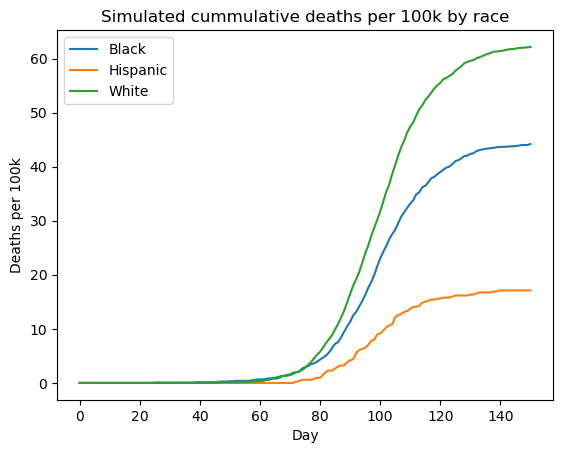

In [6]:
plt.title('Simulated cummulative deaths per 100k by race')
plt.xlabel('Day')
plt.ylabel('Deaths per 100k')
plt.plot(sim_deaths['day'], sim_deaths['D_black_cum_per100k'], label='Black')
plt.plot(sim_deaths['day'], sim_deaths['D_hispanic_cum_per100k'], label='Hispanic')
plt.plot(sim_deaths['day'], sim_deaths['D_white_cum_per100k'], label='White')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
plt.show()

### 5.3.2 Plotting observed deaths by subgroup
You'll notice some jumps in the plots of cumulative deaths per 100k which are likely due to reporting discrepancies in the raw data.

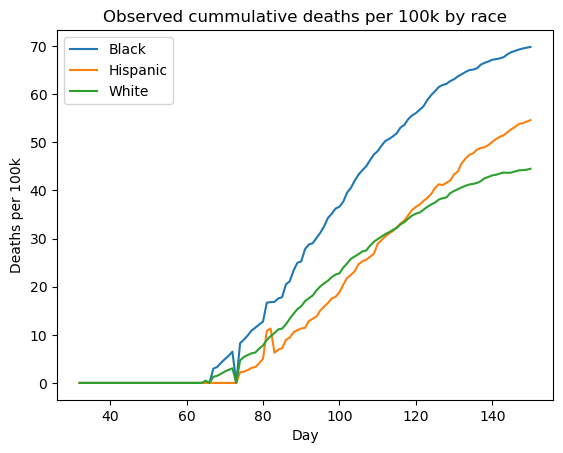

In [7]:
obs_deaths = pd.read_csv(f'{path}/observed_by_subgroup.csv') # Read in observed data
plt.title('Observed cummulative deaths per 100k by race')
plt.xlabel('Day')
plt.ylabel('Deaths per 100k')
plt.plot(obs_deaths['day'], obs_deaths['D_obs_black_per100k'], label='Black')
plt.plot(obs_deaths['day'], obs_deaths['D_obs_hispanic_per100k'], label='Hispanic')
plt.plot(obs_deaths['day'], obs_deaths['D_obs_white_per100k'], label='White')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
plt.show()

You can see that with the current parameters, the model does a decent job of capturing deaths by race. It doesn't capture the order of disparities in deaths by race, but that doesn't mean it's not capable of doing so! You may want to do more fine-tune calibration and assign different parameters to different subgroups the same way Covasim assigns different parameters by age groups. This tutorial will not explain how to do this, but now you have a synthetic population that is demographically similar to your population of interest to work with! You can then customize Covasim for your own research questions.